# Asynchronous Inference with OpenVINO™
This notebook demonstrates how to use the [Async API](https://docs.openvino.ai/nightly/openvino_docs_deployment_optimization_guide_common.html) for asynchronous execution with OpenVINO.

OpenVINO Runtime supports inference in either synchronous or asynchronous mode. The key advantage of the Async API is that when a device is busy with inference, the application can perform other tasks in parallel (for example, populating inputs or scheduling other requests) rather than wait for the current inference to complete first.

#### Table of contents:
- [Imports](#Imports)
- [Prepare model and data processing](#Prepare-model-and-data-processing)
    - [Download test model](#Download-test-model)
    - [Load the model](#Load-the-model)
    - [Create functions for data processing](#Create-functions-for-data-processing)
    - [Get the test video](#Get-the-test-video)
- [How to improve the throughput of video processing](#How-to-improve-the-throughput-of-video-processing)
    - [Sync Mode (default)](#Sync-Mode-(default))
    - [Test performance in Sync Mode](#Test-performance-in-Sync-Mode)
    - [Async Mode](#Async-Mode)
    - [Test the performance in Async Mode](#Test-the-performance-in-Async-Mode)
    - [Compare the performance](#Compare-the-performance)
- [`AsyncInferQueue`](#AsyncInferQueue)
    - [Setting Callback](#Setting-Callback)
    - [Test the performance with `AsyncInferQueue`](#Test-the-performance-with-AsyncInferQueue)


## Imports
[back to top ⬆️](#Table-of-contents:)


In [1]:
%pip install -q "openvino>=2023.1.0"
%pip install -q opencv-python matplotlib

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import cv2
import time
import numpy as np
import openvino as ov
from IPython import display
import matplotlib.pyplot as plt

# Fetch the notebook utils script from the openvino_notebooks repo
import urllib.request
urllib.request.urlretrieve(
    url='https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/main/notebooks/utils/notebook_utils.py',
    filename='notebook_utils.py'
)

import notebook_utils as utils

## Prepare model and data processing
[back to top ⬆️](#Table-of-contents:)

### Download test model
[back to top ⬆️](#Table-of-contents:)

We use a pre-trained model from OpenVINO's [Open Model Zoo](https://docs.openvino.ai/nightly/model_zoo.html) to start the test. In this case, the model will be executed to detect the person in each frame of the video.

In [3]:
# directory where model will be downloaded
base_model_dir = "model"

# model name as named in Open Model Zoo
model_name = "person-detection-0202"
precision = "FP16"
model_path = (
    f"model/intel/{model_name}/{precision}/{model_name}.xml"
)
download_command = f"omz_downloader " \
                   f"--name {model_name} " \
                   f"--precision {precision} " \
                   f"--output_dir {base_model_dir} " \
                   f"--cache_dir {base_model_dir}"
! $download_command

################|| Downloading person-detection-0202 ||################

========== Downloading model/intel/person-detection-0202/FP16/person-detection-0202.xml
... 100%, 248 KB, 368 KB/s, 0 seconds passed

========== Downloading model/intel/person-detection-0202/FP16/person-detection-0202.bin
... 100%, 3549 KB, 2313 KB/s, 1 seconds passed



### Load the model
[back to top ⬆️](#Table-of-contents:)


In [4]:
# initialize OpenVINO runtime
core = ov.Core()

# read the network and corresponding weights from file
model = core.read_model(model=model_path)

# compile the model for the CPU (you can choose manually CPU, GPU etc.)
# or let the engine choose the best available device (AUTO)
compiled_model = core.compile_model(model=model, device_name="CPU")

# get input node
input_layer_ir = model.input(0)
N, C, H, W = input_layer_ir.shape
shape = (H, W)

### Create functions for data processing
[back to top ⬆️](#Table-of-contents:)


In [5]:
def preprocess(image):
    """
    Define the preprocess function for input data
    
    :param: image: the orignal input frame
    :returns:
            resized_image: the image processed
    """
    resized_image = cv2.resize(image, shape)
    resized_image = cv2.cvtColor(np.array(resized_image), cv2.COLOR_BGR2RGB)
    resized_image = resized_image.transpose((2, 0, 1))
    resized_image = np.expand_dims(resized_image, axis=0).astype(np.float32)
    return resized_image


def postprocess(result, image, fps):
    """
    Define the postprocess function for output data
    
    :param: result: the inference results
            image: the orignal input frame
            fps: average throughput calculated for each frame
    :returns:
            image: the image with bounding box and fps message
    """
    detections = result.reshape(-1, 7)
    for i, detection in enumerate(detections):
        _, image_id, confidence, xmin, ymin, xmax, ymax = detection
        if confidence > 0.5:
            xmin = int(max((xmin * image.shape[1]), 10))
            ymin = int(max((ymin * image.shape[0]), 10))
            xmax = int(min((xmax * image.shape[1]), image.shape[1] - 10))
            ymax = int(min((ymax * image.shape[0]), image.shape[0] - 10))
            cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)
            cv2.putText(image, str(round(fps, 2)) + " fps", (5, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 3) 
    return image

### Get the test video
[back to top ⬆️](#Table-of-contents:)


In [6]:
video_path = 'https://storage.openvinotoolkit.org/repositories/openvino_notebooks/data/data/video/CEO%20Pat%20Gelsinger%20on%20Leading%20Intel.mp4'

## How to improve the throughput of video processing
[back to top ⬆️](#Table-of-contents:)

Below, we compare the performance of the synchronous and async-based approaches:

### Sync Mode (default)
[back to top ⬆️](#Table-of-contents:)

Let us see how video processing works with the default approach.<br />
Using the synchronous approach, the frame is captured with OpenCV and then immediately processed:

![drawing](https://user-images.githubusercontent.com/91237924/168452573-d354ea5b-7966-44e5-813d-f9053be4338a.png)

```
while(true) {
// capture frame
// populate CURRENT InferRequest
// Infer CURRENT InferRequest
//this call is synchronous
// display CURRENT result
}
```
```

In [7]:
def sync_api(source, flip, fps, use_popup, skip_first_frames):
    """
    Define the main function for video processing in sync mode
    
    :param: source: the video path or the ID of your webcam
    :returns:
            sync_fps: the inference throughput in sync mode
    """
    frame_number = 0
    infer_request = compiled_model.create_infer_request()
    player = None
    try:
        # Create a video player
        player = utils.VideoPlayer(source, flip=flip, fps=fps, skip_first_frames=skip_first_frames)
        # Start capturing
        start_time = time.time()
        player.start()
        if use_popup:
            title = "Press ESC to Exit"
            cv2.namedWindow(title, cv2.WINDOW_GUI_NORMAL | cv2.WINDOW_AUTOSIZE)
        while True:
            frame = player.next()
            if frame is None:
                print("Source ended")
                break
            resized_frame = preprocess(frame)
            infer_request.set_tensor(input_layer_ir, ov.Tensor(resized_frame))
            # Start the inference request in synchronous mode 
            infer_request.infer()
            res = infer_request.get_output_tensor(0).data
            stop_time = time.time()
            total_time = stop_time - start_time
            frame_number = frame_number + 1
            sync_fps = frame_number / total_time 
            frame = postprocess(res, frame, sync_fps)
            # Display the results
            if use_popup:
                cv2.imshow(title, frame)
                key = cv2.waitKey(1)
                # escape = 27
                if key == 27:
                    break
            else:
                # Encode numpy array to jpg
                _, encoded_img = cv2.imencode(".jpg", frame, params=[cv2.IMWRITE_JPEG_QUALITY, 90])
                # Create IPython image
                i = display.Image(data=encoded_img)
                # Display the image in this notebook
                display.clear_output(wait=True)
                display.display(i)         
    # ctrl-c
    except KeyboardInterrupt:
        print("Interrupted")
    # Any different error
    except RuntimeError as e:
        print(e)
    finally:
        if use_popup:
            cv2.destroyAllWindows()
        if player is not None:
            # stop capturing
            player.stop()
        return sync_fps

### Test performance in Sync Mode
[back to top ⬆️](#Table-of-contents:)


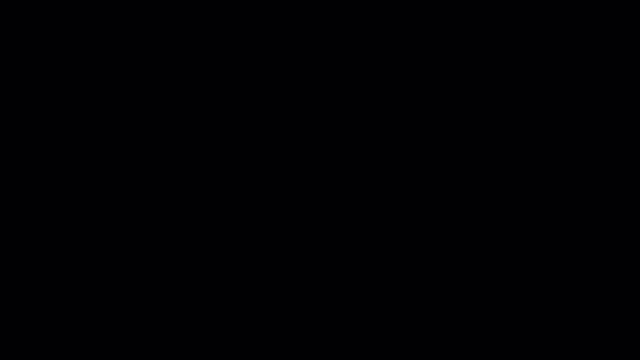

Source ended
average throuput in sync mode: 62.92 fps


In [8]:
sync_fps = sync_api(source=video_path, flip=False, fps=30, use_popup=False, skip_first_frames=800)
print(f"average throuput in sync mode: {sync_fps:.2f} fps")

### Async Mode
[back to top ⬆️](#Table-of-contents:)

Let us see how the OpenVINO Async API can improve the overall frame rate of an application. The key advantage of the Async approach is as follows: while a device is busy with the inference, the application can do other things in parallel (for example, populating inputs or scheduling other requests) rather than wait for the current inference to complete first.

![drawing](https://user-images.githubusercontent.com/91237924/168452572-c2ff1c59-d470-4b85-b1f6-b6e1dac9540e.png)

In the example below, inference is applied to the results of the video decoding. So it is possible to keep multiple infer requests, and while the current request is processed, the input frame for the next is being captured. This essentially hides the latency of capturing, so that the overall frame rate is rather determined only by the slowest part of the pipeline (decoding vs inference) and not by the sum of the stages.

```
while(true) {
// capture frame
// populate NEXT InferRequest
// start NEXT InferRequest
// this call is async and returns immediately
// wait for the CURRENT InferRequest
// display CURRENT result
// swap CURRENT and NEXT InferRequests
}
```

In [9]:
def async_api(source, flip, fps, use_popup, skip_first_frames):
    """
    Define the main function for video processing in async mode
    
    :param: source: the video path or the ID of your webcam
    :returns:
            async_fps: the inference throughput in async mode
    """
    frame_number = 0
    # Create 2 infer requests
    curr_request = compiled_model.create_infer_request()
    next_request = compiled_model.create_infer_request()
    player = None
    async_fps = 0
    try:
        # Create a video player
        player = utils.VideoPlayer(source, flip=flip, fps=fps, skip_first_frames=skip_first_frames)
        # Start capturing
        start_time = time.time()
        player.start()
        if use_popup:
            title = "Press ESC to Exit"
            cv2.namedWindow(title, cv2.WINDOW_GUI_NORMAL | cv2.WINDOW_AUTOSIZE)
        # Capture CURRENT frame
        frame = player.next()
        resized_frame = preprocess(frame)
        curr_request.set_tensor(input_layer_ir, ov.Tensor(resized_frame))
        # Start the CURRENT inference request
        curr_request.start_async()
        while True:
            # Capture NEXT frame
            next_frame = player.next()
            if next_frame is None:
                print("Source ended")
                break
            resized_frame = preprocess(next_frame)
            next_request.set_tensor(input_layer_ir, ov.Tensor(resized_frame))
            # Start the NEXT inference request
            next_request.start_async()
            # Waiting for CURRENT inference result
            curr_request.wait()
            res = curr_request.get_output_tensor(0).data
            stop_time = time.time()
            total_time = stop_time - start_time
            frame_number = frame_number + 1
            async_fps = frame_number / total_time  
            frame = postprocess(res, frame, async_fps)
            # Display the results
            if use_popup:
                cv2.imshow(title, frame)
                key = cv2.waitKey(1)
                # escape = 27
                if key == 27:
                    break
            else:
                # Encode numpy array to jpg
                _, encoded_img = cv2.imencode(".jpg", frame, params=[cv2.IMWRITE_JPEG_QUALITY, 90])
                # Create IPython image
                i = display.Image(data=encoded_img)
                # Display the image in this notebook
                display.clear_output(wait=True)
                display.display(i)
            # Swap CURRENT and NEXT frames
            frame = next_frame
            # Swap CURRENT and NEXT infer requests
            curr_request, next_request = next_request, curr_request         
    # ctrl-c
    except KeyboardInterrupt:
        print("Interrupted")
    # Any different error
    except RuntimeError as e:
        print(e)
    finally:
        if use_popup:
            cv2.destroyAllWindows()
        if player is not None:
            # stop capturing
            player.stop()
        return async_fps

### Test the performance in Async Mode
[back to top ⬆️](#Table-of-contents:)


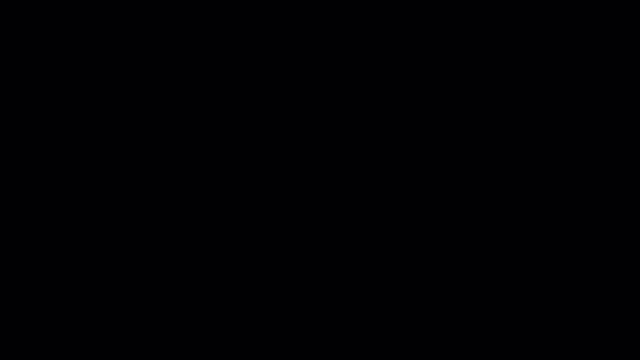

Source ended
average throuput in async mode: 98.78 fps


In [10]:
async_fps = async_api(source=video_path, flip=False, fps=30, use_popup=False, skip_first_frames=800)
print(f"average throuput in async mode: {async_fps:.2f} fps")

### Compare the performance
[back to top ⬆️](#Table-of-contents:)


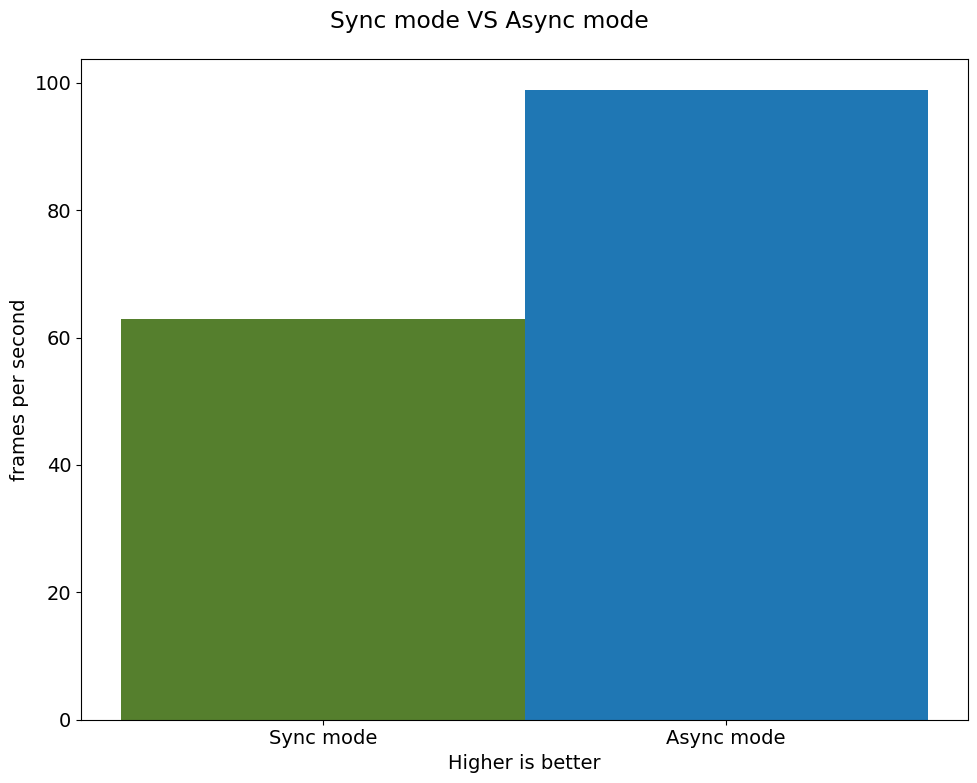

In [11]:
width = 0.4
fontsize = 14

plt.rc('font', size=fontsize)
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

rects1 = ax.bar([0], sync_fps, width, color='#557f2d')
rects2 = ax.bar([width], async_fps, width)
ax.set_ylabel("frames per second")
ax.set_xticks([0, width]) 
ax.set_xticklabels(["Sync mode", "Async mode"])
ax.set_xlabel("Higher is better")

fig.suptitle('Sync mode VS Async mode')
fig.tight_layout()

plt.show()

## `AsyncInferQueue`
[back to top ⬆️](#Table-of-contents:)

Asynchronous mode pipelines can be supported with the [`AsyncInferQueue`](https://docs.openvino.ai/2023.0/openvino_docs_OV_UG_Python_API_exclusives.html#asyncinferqueue) wrapper class. This class automatically spawns the pool of `InferRequest` objects (also called “jobs”) and provides synchronization mechanisms to control the flow of the pipeline. It is a simpler way to manage the infer request queue in Asynchronous mode.

### Setting Callback
[back to top ⬆️](#Table-of-contents:)

When `callback` is set, any job that ends inference calls upon the Python function. The `callback` function must have two arguments: one is the request that calls the `callback`, which provides the `InferRequest` API; the other is called “user data”, which provides the possibility of passing runtime values.

In [12]:
def callback(infer_request, info) -> None:
    """
    Define the callback function for postprocessing
    
    :param: infer_request: the infer_request object
            info: a tuple includes original frame and starts time
    :returns:
            None
    """
    global frame_number
    global total_time
    global inferqueue_fps
    stop_time = time.time()
    frame, start_time = info
    total_time = stop_time - start_time
    frame_number = frame_number + 1
    inferqueue_fps = frame_number / total_time
    
    res = infer_request.get_output_tensor(0).data[0]
    frame = postprocess(res, frame, inferqueue_fps)
    # Encode numpy array to jpg
    _, encoded_img = cv2.imencode(".jpg", frame, params=[cv2.IMWRITE_JPEG_QUALITY, 90])
    # Create IPython image
    i = display.Image(data=encoded_img)
    # Display the image in this notebook
    display.clear_output(wait=True)
    display.display(i)

In [13]:
def inferqueue(source, flip, fps, skip_first_frames) -> None:
    """
    Define the main function for video processing with async infer queue
    
    :param: source: the video path or the ID of your webcam
    :retuns:
        None
    """
    # Create infer requests queue
    infer_queue = ov.AsyncInferQueue(compiled_model, 2)
    infer_queue.set_callback(callback)
    player = None
    try:
        # Create a video player
        player = utils.VideoPlayer(source, flip=flip, fps=fps, skip_first_frames=skip_first_frames)
        # Start capturing
        start_time = time.time()
        player.start()
        while True:
            # Capture frame
            frame = player.next()
            if frame is None:
                print("Source ended")
                break
            resized_frame = preprocess(frame)
            # Start the inference request with async infer queue 
            infer_queue.start_async({input_layer_ir.any_name: resized_frame}, (frame, start_time))
    except KeyboardInterrupt:
        print("Interrupted")
    # Any different error
    except RuntimeError as e:
        print(e)
    finally:
        infer_queue.wait_all()
        player.stop()

### Test the performance with `AsyncInferQueue`
[back to top ⬆️](#Table-of-contents:)


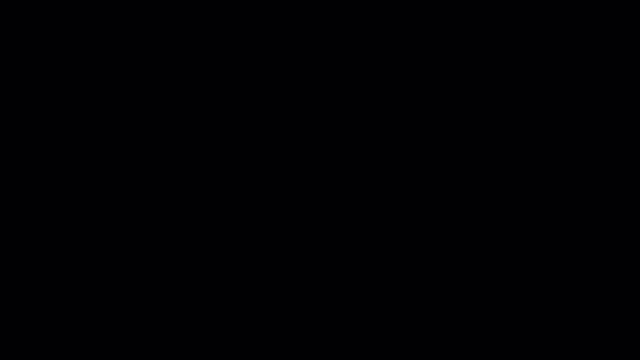

average throughput in async mode with async infer queue: 110.84 fps


In [14]:
frame_number = 0
total_time = 0
inferqueue(source=video_path, flip=False, fps=30, skip_first_frames=800)
print(f"average throughput in async mode with async infer queue: {inferqueue_fps:.2f} fps")